## Иммитационная модель экономической безопасности региона

# Алгоритм работы:

1. Используемые библиотеки

2. Создание классов для автоматизации расчета

3. Подгрузка данных Росстат для прогнозирования ЭБР

4. Выбор данных и их очистка для формирования фрейма

5. Подработка данных. Удаление нулевых значений, изменение формата данных для расчетов, расширение данных

6. Отбор влияющих факторов, корреляция и сортировка

7. Формирование таблицы для предикта по Омской области

8. Обучение моделей XGBoost

9. Прогноз и оценка факторов ЭБР с помощью вектора Шепли

10. Выделение факторов ЭБР для построения иммитационной модели.
Построение иммитационной модели в EGT


## Дополнительная теория
Гиперпараметры — это характеристики модели, которые фиксируются до начала обучения: глубина решающего дерева, значение силы регуляризации в линейной модели, learning rate для бэггинга.
GridSearchCV

Самый естественный способ организовать перебор наборов гиперпараметров — сделать перебор по сетке (Grid Search):

для каждого гиперпараметра фиксируется несколько значений;
перебираются все комбинации значений различных гиперпараметров, на каждой из этих комбинаций модель обучается и тестируется;
выбирается комбинация, на которой модель показывает лучшее качество.
(Random Search – иной способ подбора, для каждого гиперпараметра задаётся распределение, из которого выбирается его значение, и комбинация гиперпараметров составляется семплированием из этих распределений).

Взаимодействие факторов:
Факторы взаимодействуют друг с другом в процессе подготовки данных и обучения модели, через методы класса ColumnHandler:

Каждый метод класса ColumnHandler представляет собой операцию агрегации данных по определенным категориям или условиям.

В коде используется экстремальный бустинг для построения модели прогнозирования. Мы создаем экземпляр модели, указывая оптимальные гипперпараметры, найденные с помощью решетчатого поиска (GridSearchCV).

Затем модель обучается на обучающих данных с помощью метода fit(), а затем используется для предсказания на тестовых данных с помощью метода predict(). После этого оценивается качество модели с помощью метрик, таких как коэффициент детерминации (R^2 score), среднеквадратичная ошибка (MSE) и RMSE.

Экстремальный бустинг выбран из-за его высокой производительности и эффективности в решении задач регрессии. Он хорошо подходит для работы с большими объемами данных и способен обрабатывать различные типы признаков. Также он имеет встроенную поддержку решетчатого поиска для оптимизации гиперпараметров.

В коде используются следующие коэффициенты для экстремального бустинга: learning_rate, max_depth, n_estimators и random_state.

Вектор шелпи (Shapley values)
является методом объяснения предсказаний модели машинного обучения. Он используется для оценки вклада каждого признака в прогноз модели. В регрессионных моделях прогноза вектор шелпи может быть полезен для понимания того, какие признаки оказывают наибольшее влияние на прогнозы модели. Преимущества использования вектора шелпи в регрессионных моделях:

Интерпретируемость: Вектор шелпи позволяет интерпретировать причину прогнозов модели, показывая важность каждого признака для конкретного предсказания.
Отслеживание изменений: При изменении значений признаков можно использовать вектор шелпи для понимания, как изменится прогноз модели.
Помощь в принятии решений: Анализ вектора шелпи может помочь принять решения на основе важности различных признаков.

В качестве иммитационной модели ЭБР выбрана базовая EGT. Создать игру в 3-мерном симплексе для выбора между негативным и позитивным влиянием факторов.

Создаем игру на 3-ом симплексе, находим устойчивые точки покоя системы дифференциальных уравнений, описывающих динамику системы (https://egttools.readthedocs.io/_/downloads/en/stable/pdf/) - они отвечают эволюционно устойчивым состоянием.

В данном приближении используется модель бесконечного набора факторов ЭБР, динамика распределения по стратегиям которого описывается с помощью уравнения:
$$ \dot{x_i} = x_i ((Ax)_i - x^TAx)$$
A - матрица влияния   

## Используемые библиотеки

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import xgboost as xgb
import seaborn as sns
%pip install shap
import shap
from pandas import read_csv, DataFrame

from statsmodels.iolib.table import SimpleTable
from sklearn.metrics import r2_score
from matplotlib import pyplot
pd.options.display.float_format ='{:,.3f}'.format
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
import warnings
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_predict
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_squared_log_error
from typing import Dict, Any, List

pd.options.display.float_format ='{:,.3f}'.format
warnings.filterwarnings("ignore")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.1/540.1 kB 3.2 MB/s eta 0:00:00


## Классы для оптимизации вычислений

In [ ]:
#Метрики
def my_result(y_test: List[float], y_pred: List[float], title: str) -> None:
    # Оценка качества модели на тестовой выборке
    print(f"R^2 score: {r2_score(y_test, y_pred)}")

    # Расчет MSE и RMSE на тестовой выборке
    print("MSE на тестовой выборке:", mean_squared_error(y_test, y_pred))
    print("RMSE на тестовой выборке:", mean_squared_error(y_test, y_pred, squared=False))

    # Расчет MAE
    mae = mean_absolute_error(y_test, y_pred)
    print("MAE на тестовой выборке:", mae)

    # Расчет MAPE
    mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
    print("MAPE на тестовой выборке:", mape)

    # Расчет WAPE
    wape = np.sum(np.abs(y_test - y_pred)) / np.sum(y_test) * 100
    print("WAPE на тестовой выборке:", wape)

    # Расчет SMAPE
    smape = 2 * np.mean(np.abs(y_test - y_pred) / (np.abs(y_test) + np.abs(y_pred))) * 100
    print("SMAPE на тестовой выборке:", smape)

    # визуализация прогноза модели
    plt.scatter(y_test, y_pred)
    plt.plot([2014, max(y_test)], [2014, max(y_pred)], 'k--', lw=2)
    plt.ylabel('Реальные значения')
    plt.xlabel('Предсказанные значения')
    plt.title(title)
    plt.show()

In [ ]:
# Решетчатый метод
def find_best_params(X_train: Any, y_train: Any, random_seed: int) -> Dict[str, Any]:
    # задаем параметры для поиска по сетке
    param_grid = {'learning_rate': [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35],
                  'max_depth': [2, 3, 4],
                  'n_estimators': list(range(10, 200, 10)),
                  'random_state': [random_seed]}
    # создаем модель
    gb_model = GradientBoostingRegressor()

    # создаем объект GridSearchCV для поиска по сетке
    grid_search = GridSearchCV(gb_model, param_grid, cv=5)

    # обучаем модель
    grid_search.fit(X_train, y_train)

    return grid_search.best_params_

In [ ]:
# Функция для расчета важности признаков
def show_feature_importances(model: RandomForestRegressor, features: List[str]) -> pd.DataFrame:
    plt.figure(figsize=(12, 8))

    # Создадим датафрейм фич и их важностей и отсортируем его
    results = pd.DataFrame({'feature': features, 'importance': model.feature_importances_})
    results = results.sort_values('importance', ascending=False)

    # Отображение
    print(results.head(10))
    print('n Признаков с важностью выше 0.01 = ', np.sum(results['importance'] > 0.01))

    # График
    results.head(20).plot(x='feature', y='importance', kind='barh',
                          color='red', edgecolor='k', title='Feature Importances')
    return results

In [ ]:
# Матрица корреляции
class MatrixCorrelation:
    def __init__(self, processed_df: pd.DataFrame) -> None:
        self.processed_df = processed_df

    def matrix(self) -> pd.DataFrame:
        correlation = self.processed_df.corr()
        return correlation

    def graph(self) -> None:
        correlation = self.matrix()
        plt.figure(figsize=(20, 15))
        sns.heatmap(correlation, annot=True, cmap='coolwarm')
        plt.title('Correlation Matrix')
        plt.show()


## Данные для построения статистической модели ЭБР (данные Росстат)

|Название поля 	 |Описание      	                              |Название поля   |Описание                                  |
|:--------------:|:----------------------------------------------:|:--------------:|:----------------------------------------:|
|**ВРП**       |ВРП по ОКВЭД-2    | **03.48.38.05** | Задолженность юрлиц и ИП по кредитам
|**03.48.38.06** | Сведения о задолженности по кредитам юридических лиц-резидентов и индивидуальных предпринимателей в рублях по видам экономической деятельности и отдельным направлениям использования средствм |**03.48.38.08** | Сведения об объемах кредитования юридических лиц-резидентов и индивидуальных предпринимателей в иностранной валюте
|**03.48.38.09** | Сведения об объемах кредитования юридических лиц-резидентов и индивидуальных предпринимателей в рублях по видам экономической деятельности и отдельным направлениям использования средств использования средств | **9460370** | Отгружено товаров собственного производства, выполнено работ и услуг собственными силами инновационного характера с 2017 г.
| **9460394** | Общий объем заказов на поставку продукции в последующие периоды с 2017 г. | **9460728** | Количество организаций по данным государственной регистрации с 2017 г.
| **9460762** | Оплата услуг рекламных агентств и аудиторских организаций за счет прибыли с 2017 г. | **9460763** | Расходы по предоставлению услуг образования за счет прибыли с 2017 г.
| **9460766** | Оплата сторонних организаций по предоставлению услуг лечебных и санаторно-курортных учреждений за счет прибыли с 2017 г. | **9460766** | Оплата сторонних организаций по предоставлению услуг лечебных и санаторно-курортных учреждений за счет прибыли с 2017 г.
| **9460767** | Надбавки к пенсиям, единовременные пособия уходящим на пенсию за счет прибыли с 2017 г. | **9460766** | Оплата сторонних организаций по предоставлению услуг лечебных и санаторно-курортных учреждений за счет прибыли с 2017 г.
|**9460767** | Надбавки к пенсиям, единовременные пособия уходящим на пенсию за счет прибыли с 2017 г. | **9460768** | Оплата сторонних организаций по предоставлению услуг лечебных и санаторно-курортных учреждений с 2017 г.
|**9460769** | Расходы на благотворительные цели за счет прибыли с 2017 г. | **9460768** | Оплата сторонних организаций по предоставлению услуг лечебных и санаторно-курортных учреждений с 2017 г.
|**1229015**        |Объем отгруженных товаров представляет собой стоимость всех товаров и услуг в фактических ценах, произведеных юридическим лицом, тыс.руб. 	                              |**9461232**       |Доля инвестиций в машины и оборудование в общем объеме инвестиций в основной капитал, направленных на реконструкцию и модернизацию (по организациям, не относящимся к субъектам малого предпринимательства в разрезе ОКВЭД2), %                                    |
|**9461231**   |Доля инвестиций, направленных на реконструкцию и модернизацию в общем объеме инвестиций в основной капитал (по организациям, не относящимся к субъектам малого предпринимательства в разрезе ОКВЭД2), %        	                              |**9460785**        |Долгосрочные инвестиции по обычным видам деятельности, тыс.руб.                      |
|**2112020**   |Оплата сторонних организаций по предоставлению услуг лечебных и санаторно-курортных учреждений, тыс.руб. 	                          |**9460772**         |Оплата услуг банков и других финансово-кредитных учреждений, тыс.руб.
|**9460797**    |Расходы на научно-исследовательские работы, тыс.руб.                                          |**2112081**        |Расходы по предоставлению услуг физкультурно-оздоровительной деятельности, тыс.руб.  	                              
|**9460778**| Расходы по предоставлению услуг образования, тыс.руб.                  |**9460474**| Задолженность по платежам в бюджет, тыс.руб.  
|**9460851**| Затраты на производство и реализацию продукции (товаров, работ,услуг),тыс.руб. |**9470022**| Среднемесячные затраты на рабочую силу в расчете на одного работника, руб. |
|**9460844**   |Основные средства, тыс.руб. 	                          |**9460520**         |Оборотные средства, тыс.руб. |
|**1416016**   |Запасы на начало отчетного периода, тыс.руб. 	                          |**9460507**         |Просроченная задолженность, тыс.руб. |
|**9460470**   |Удельный вес прибыльных организаций, %	                          |**9461250**         |Среднесписочная численность работников по полному кругу организаций , чел. |
|**9460853**   |Установной капитал (фонд), тыс.руб.	                          |**9460840**         |Управленческие расходы, тыс.руб. |


In [ ]:
df = pd.read_excel('/var/ichod.xlsx')
df.sort_index(ascending=True)

with pd.option_context('display.max_columns', None):
    display(df)
df.info()

,Unnamed: 0,Регион,ОКВЭД,Год,ВРП,id_9460762,id_9460769_x,#2112020,id_9460768,id_9460767,id_9460769_y,id_9460763_x,id_9460763_y,#9460778_x,#9460778_y,#9460797,#9460851
0,0,РОССИЙСКАЯФЕДЕРАЦИЯ,"СЕЛЬСКОЕ,ЛЕСНОЕХОЗЯЙСТВО,ОХОТА,РЫБОЛОВСТВОИРЫБ...",2017,"3,512,633,132.000",161728,1657158,23075,23075,140667,1657158,2449,2449,9514,9514,152627,"7,584,470.500"
1,1,РОССИЙСКАЯФЕДЕРАЦИЯ,"СЕЛЬСКОЕ,ЛЕСНОЕХОЗЯЙСТВО,ОХОТА,РЫБОЛОВСТВОИРЫБ...",2018,"3,577,570,690.300",173466,2242755,21561,21561,146052,2242755,1300,1300,10458,10458,31769,"6,932,181.600"
2,2,РОССИЙСКАЯФЕДЕРАЦИЯ,"СЕЛЬСКОЕ,ЛЕСНОЕХОЗЯЙСТВО,ОХОТА,РЫБОЛОВСТВОИРЫБ...",2021,"3,870,190,165.500",274458,2298870,13526,13526,134831,2298870,63,63,7732,7732,31323,"4,802,556.900"
3,3,РОССИЙСКАЯФЕДЕРАЦИЯ,ДОБЫЧАПОЛЕЗНЫХИСКОПАЕМЫХ,2017,"7,714,066,383.000",137413,24292442,458019,458019,1007911,24292442,9623,9623,267121,267121,1947315,"3,345,573.500"
4,4,РОССИЙСКАЯФЕДЕРАЦИЯ,ДОБЫЧАПОЛЕЗНЫХИСКОПАЕМЫХ,2018,"8,175,398,779.800",210778,22365123,532879,532879,1311246,22365123,12485,12485,308822,308822,2783541,"3,247,449.600"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139729,139729,ХАБАРОВСКИЙКРАЙ,ВСЕГОПООБСЛЕДУЕМЫМВИДАМЭКОНОМИЧЕСКОЙДЕЯТЕЛЬНОСТИ,2018,"695,469,723.500",41729,421283,13209,13209,43260,421283,144,144,1821,1821,238720,"2,857,880.600"
139730,139730,ХАБАРОВСКИЙКРАЙ,ВСЕГОПООБСЛЕДУЕМЫМВИДАМЭКОНОМИЧЕСКОЙДЕЯТЕЛЬНОСТИ,2021,"722,725,850.000",32822,244311,10695,10695,27722,244311,92,92,10612,10612,132169,"3,011,554.300"
139731,139731,АМУРСКАЯОБЛАСТЬ,СТРОИТЕЛЬСТВО,2017,"24,671,950.000",80,2093,0,0,0,2093,0,0,0,0,0,"61,174.000"
139732,139732,АМУРСКАЯОБЛАСТЬ,ВСЕГОПООБСЛЕДУЕМЫМВИДАМЭКОНОМИЧЕСКОЙДЕЯТЕЛЬНОСТИ,2017,"289,537,390.900",29625,147493,0,0,33612,147493,0,0,0,0,31799,"296,418.300"


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 139734 entries, 0 to 139733
Data columns (total 17 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Unnamed: 0    139734 non-null  int64  
 1   Регион        139734 non-null  object 
 2   ОКВЭД         139734 non-null  object 
 3   Год           139734 non-null  int64  
 4   ВРП           139734 non-null  float64
 5   id_9460762    139734 non-null  int64  
 6   id_9460769_x  139734 non-null  int64  
 7   #2112020      139734 non-null  int64  
 8   id_9460768    139734 non-null  int64  
 9   id_9460767    139734 non-null  int64  
 10  id_9460769_y  139734 non-null  int64  
 11  id_9460763_x  139734 non-null  int64  
 12  id_9460763_y  139734 non-null  int64  
 13  #9460778_x    139734 non-null  int64  
 14  #9460778_y    139734 non-null  int64  
 15  #9460797      139734 non-null  int64  
 16  #9460851      139734 non-null  float64
dtypes: float64(2), int64(13), object(2)
memory usage

In [ ]:
#Выделение Омской области для подвыборки
target_variable_name = 'ВРП'
Omsktest=df[df['Регион'] == 'ОМСКАЯОБЛАСТЬ']
Omsktest=Omsktest._get_numeric_data()
Omsktest=Omsktest.drop(target_variable_name, axis=1)
del Omsktest['Год']
del Omsktest['Unnamed: 0']

In [ ]:
#Подработка основной выборки
DF=df._get_numeric_data()
DF=DF.round(2)
del DF['Год']
del DF['Unnamed: 0']

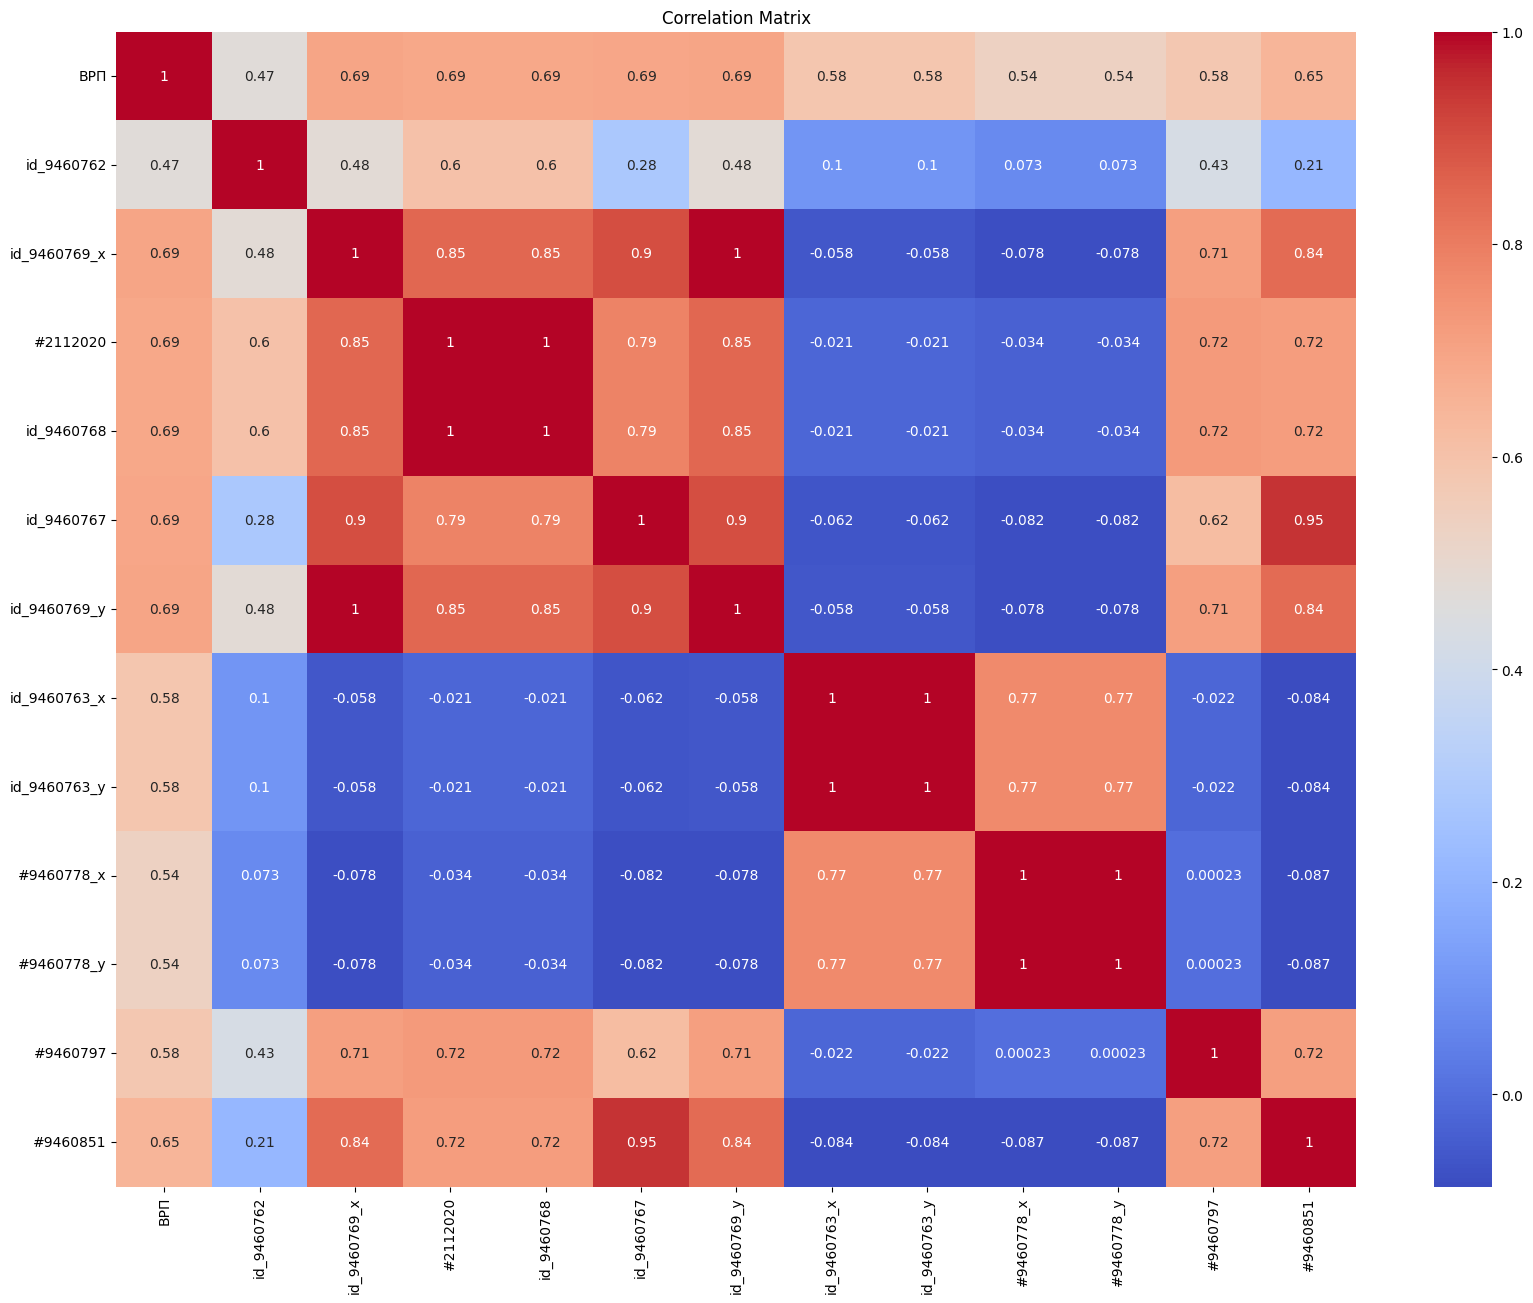

In [ ]:
matri = MatrixCorrelation(DF)
matri.matrix()
matri.graph()

In [ ]:
# Корреляция и сортировка
correlations = DF.corr()['ВРП'].sort_values()
# Отображение
print('Наивысшая позитивная корреляция: n', correlations.tail(15))
print('nНаивысшая негативная корреляция: n', correlations.head(15))

Наивысшая позитивная корреляция: n id_9460762     0.472
#9460778_x     0.536
#9460778_y     0.536
#9460797       0.583
id_9460763_x   0.584
id_9460763_y   0.584
#9460851       0.647
#2112020       0.689
id_9460768     0.689
id_9460767     0.692
id_9460769_x   0.694
id_9460769_y   0.694
ВРП            1.000
Name: ВРП, dtype: float64
nНаивысшая негативная корреляция: n id_9460762     0.472
#9460778_x     0.536
#9460778_y     0.536
#9460797       0.583
id_9460763_x   0.584
id_9460763_y   0.584
#9460851       0.647
#2112020       0.689
id_9460768     0.689
id_9460767     0.692
id_9460769_x   0.694
id_9460769_y   0.694
ВРП            1.000
Name: ВРП, dtype: float64


## Обучение и сравнение статистических моделей ЭБР

In [ ]:
X1 = DF.drop(columns=['ВРП'])
y1 = DF['ВРП']

In [ ]:
# разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X1, y1, test_size=0.2, random_state=70)
random_seed = 70

In [ ]:
# поиск параметрво для градиентного бустинга
#params = find_best_params(X_train, y_train, random_seed)
#params

R^2 score: 0.9847632261303203
MSE на тестовой выборке: 1.1563014221120606e+16
RMSE на тестовой выборке: 107531456.8910912
MAE на тестовой выборке: 12366656.784481358
MAPE на тестовой выборке: 18.296965594451343
WAPE на тестовой выборке: 2.4672381975038666
SMAPE на тестовой выборке: 15.338959023846273


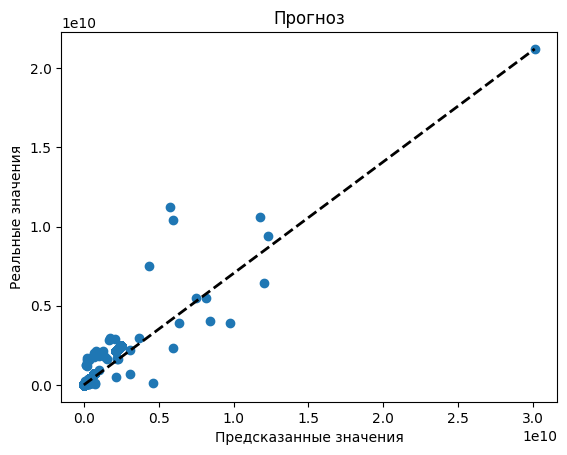

In [ ]:


# поиск параметрво для градиентного бустинга
#params = find_best_params(X_train, y_train, random_seed)
#params


paramss = {'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 90, 'random_state': 70, 'reg_alpha': 0.1}
model = xgb.XGBRegressor(**paramss)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
title = 'Прогноз'
my_result(y_test, y_pred, title)

         feature  importance
0     id_9460762       0.607
8     #9460778_x       0.207
6   id_9460763_x       0.107
4     id_9460767       0.032
10      #9460797       0.022
1   id_9460769_x       0.012
11      #9460851       0.010
2       #2112020       0.002
3     id_9460768       0.000
5   id_9460769_y       0.000
n Признаков с важностью выше 0.01 =  6


,feature,importance
0,id_9460762,0.607
8,#9460778_x,0.207
6,id_9460763_x,0.107
4,id_9460767,0.032
10,#9460797,0.022
1,id_9460769_x,0.012
11,#9460851,0.010
2,#2112020,0.002
3,id_9460768,0.000
5,id_9460769_y,0.000


<Figure size 1200x800 with 0 Axes>

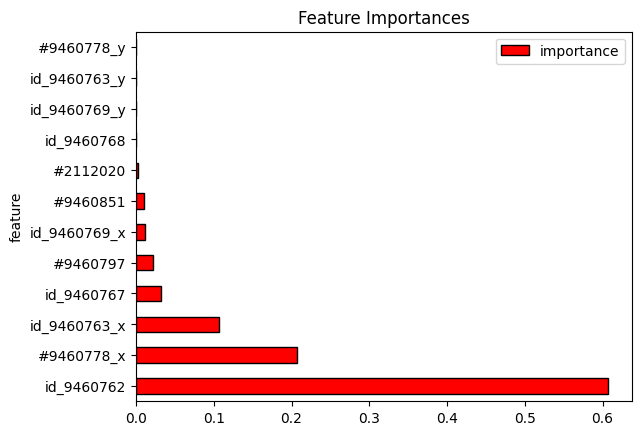

In [ ]:

show_feature_importances(model, X_train.columns)

## Вектор Шепли

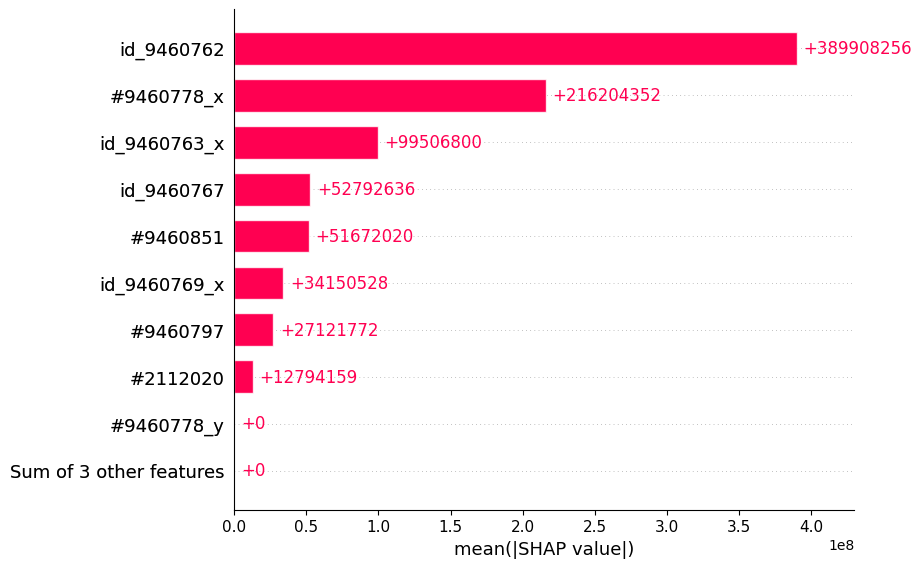

In [ ]:
explainer = shap.Explainer(model)
shap_values = explainer(X_test)
shap.plots.bar(shap_values) # среднее значение по всей выборке

In [ ]:
#проверка на Омской области
explainer = shap.Explainer(model)
shap_values = explainer(Omsktest)

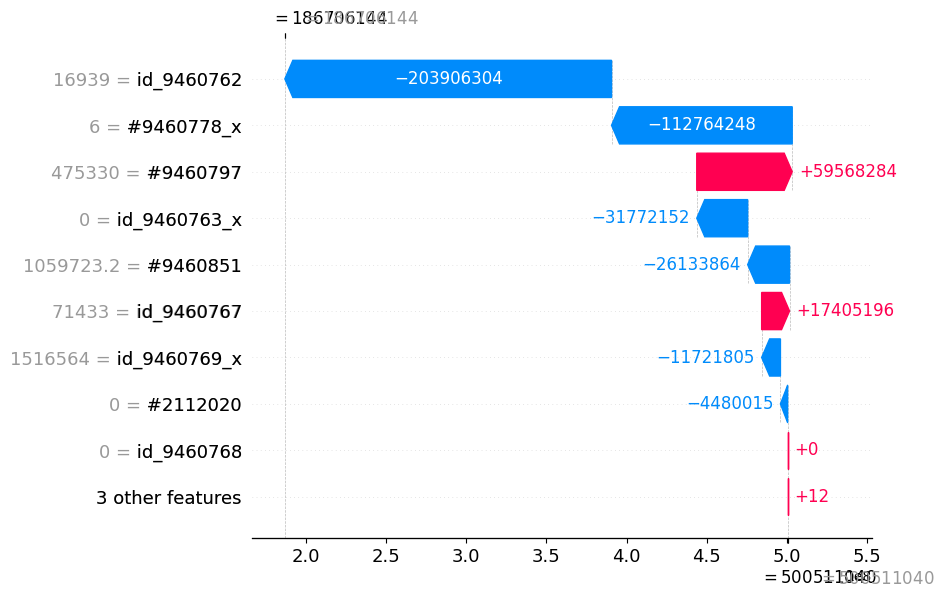

In [ ]:
shap.plots.waterfall(shap_values[5])

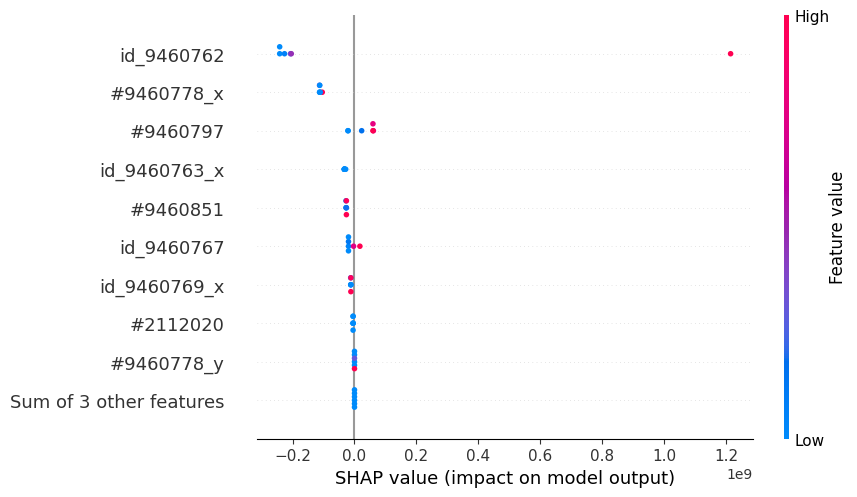

In [ ]:
shap.plots.beeswarm(shap_values)

## Иммитационная модель ЭБР

In [ ]:
shap_values # в основу возьмем полученые значимости факторов

.values =
array([[-2.0658530e+08, -1.1721825e+07, -4.4800150e+06,  0.0000000e+00,
        -1.9376642e+07,  0.0000000e+00, -3.3107326e+07,  0.0000000e+00,
        -1.1272257e+08,  0.0000000e+00,  5.9568284e+07, -2.6133864e+07],
       [-2.2578427e+08, -1.2230633e+07, -4.6007365e+06,  0.0000000e+00,
        -1.9376642e+07,  0.0000000e+00, -3.2890444e+07,  0.0000000e+00,
        -1.1028716e+08,  0.0000000e+00, -2.0377468e+07, -2.7530340e+07],
       [-2.4138696e+08, -1.2228879e+07, -4.6007365e+06,  0.0000000e+00,
        -1.9376642e+07,  0.0000000e+00, -3.2479906e+07,  0.0000000e+00,
        -1.1216874e+08,  0.0000000e+00, -2.1404842e+07, -2.7530340e+07],
       [-2.4138696e+08, -1.1719149e+07, -4.6007365e+06,  0.0000000e+00,
        -1.9376642e+07,  0.0000000e+00, -3.2551818e+07,  0.0000000e+00,
        -1.1216874e+08,  0.0000000e+00,  2.3136982e+07, -2.6540608e+07],
       [ 1.2135671e+09, -1.1721805e+07, -4.5034955e+06,  0.0000000e+00,
        -2.9943515e+06,  0.0000000e+00, -2.8344832

In [ ]:
%pip install egttools
from egttools.plotting.simplified import plot_replicator_dynamics_in_simplex

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 638.6/638.6 kB 8.7 MB/s eta 0:00:00


In [ ]:
matrix = np.array(shap_values.values)
matrix

array([[-2.0658530e+08, -1.1721825e+07, -4.4800150e+06,  0.0000000e+00,
        -1.9376642e+07,  0.0000000e+00, -3.3107326e+07,  0.0000000e+00,
        -1.1272257e+08,  0.0000000e+00,  5.9568284e+07, -2.6133864e+07],
       [-2.2578427e+08, -1.2230633e+07, -4.6007365e+06,  0.0000000e+00,
        -1.9376642e+07,  0.0000000e+00, -3.2890444e+07,  0.0000000e+00,
        -1.1028716e+08,  0.0000000e+00, -2.0377468e+07, -2.7530340e+07],
       [-2.4138696e+08, -1.2228879e+07, -4.6007365e+06,  0.0000000e+00,
        -1.9376642e+07,  0.0000000e+00, -3.2479906e+07,  0.0000000e+00,
        -1.1216874e+08,  0.0000000e+00, -2.1404842e+07, -2.7530340e+07],
       [-2.4138696e+08, -1.1719149e+07, -4.6007365e+06,  0.0000000e+00,
        -1.9376642e+07,  0.0000000e+00, -3.2551818e+07,  0.0000000e+00,
        -1.1216874e+08,  0.0000000e+00,  2.3136982e+07, -2.6540608e+07],
       [ 1.2135671e+09, -1.1721805e+07, -4.5034955e+06,  0.0000000e+00,
        -2.9943515e+06,  0.0000000e+00, -2.8344832e+07,  0.0

In [ ]:
print(matrix)
print("n =", len(matrix))
print("m =", len(matrix[0]))

[[-2.0658530e+08 -1.1721825e+07 -4.4800150e+06  0.0000000e+00
  -1.9376642e+07  0.0000000e+00 -3.3107326e+07  0.0000000e+00
  -1.1272257e+08  0.0000000e+00  5.9568284e+07 -2.6133864e+07]
 [-2.2578427e+08 -1.2230633e+07 -4.6007365e+06  0.0000000e+00
  -1.9376642e+07  0.0000000e+00 -3.2890444e+07  0.0000000e+00
  -1.1028716e+08  0.0000000e+00 -2.0377468e+07 -2.7530340e+07]
 [-2.4138696e+08 -1.2228879e+07 -4.6007365e+06  0.0000000e+00
  -1.9376642e+07  0.0000000e+00 -3.2479906e+07  0.0000000e+00
  -1.1216874e+08  0.0000000e+00 -2.1404842e+07 -2.7530340e+07]
 [-2.4138696e+08 -1.1719149e+07 -4.6007365e+06  0.0000000e+00
  -1.9376642e+07  0.0000000e+00 -3.2551818e+07  0.0000000e+00
  -1.1216874e+08  0.0000000e+00  2.3136982e+07 -2.6540608e+07]
 [ 1.2135671e+09 -1.1721805e+07 -4.5034955e+06  0.0000000e+00
  -2.9943515e+06  0.0000000e+00 -2.8344832e+07  0.0000000e+00
  -1.0397890e+08  0.0000000e+00  6.0925912e+07 -2.6133864e+07]
 [-2.0390630e+08 -1.1721805e+07 -4.4800150e+06  0.0000000e+00
   

In [ ]:
# Находим 9 самых позитивных факторов
largest_elements = np.unravel_index(np.argsort(matrix.ravel())[-9:], matrix.shape)
# Находим 9 самых негативных факторов
smallest_elements = np.unravel_index(np.argsort(matrix.ravel())[:9], matrix.shape)
# Находим 9 средних факторов
middle_elements = np.unravel_index(np.argsort(matrix.ravel())[len(matrix.ravel())//2 - 4:len(matrix.ravel())//2 + 5], matrix.shape)
# Создаем матрицу 3x3
result_matrix = np.zeros((3, 3), dtype=int)
result_matrix[:, 0] = matrix[largest_elements].reshape(3, 3)[:, 0]
result_matrix[:, 1] = matrix[middle_elements].reshape(3, 3)[:, 0]
result_matrix[:, 2] = matrix[smallest_elements].reshape(3, 3)[:, 0]

print("\nМатрица 3x3 с крупными, средними и минимальными элементами:")
print(result_matrix)


Матрица 3x3 с крупными, средними и минимальными элементами:
[[         0  -11721805 -241386960]
 [  17405196   -4600736 -206585296]
 [  59568284   -4503495 -112722568]]


(-0.02, 0.9160254037844386)

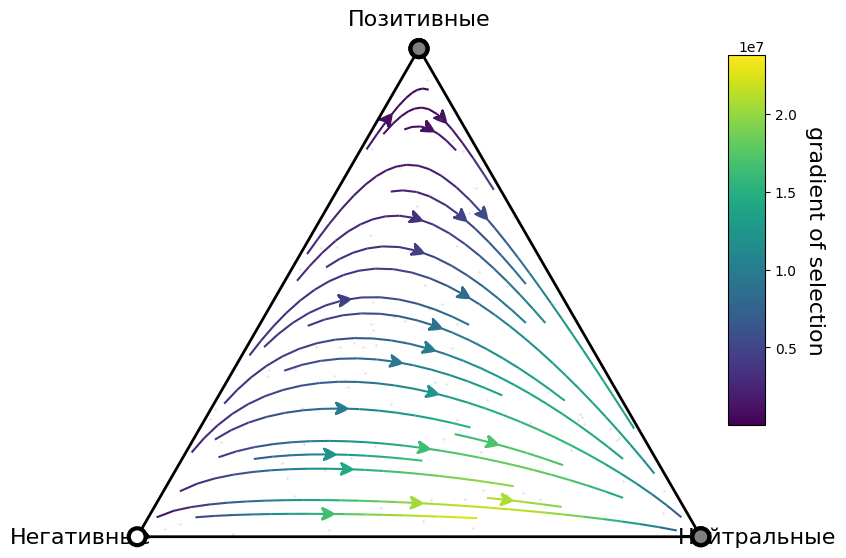

In [ ]:
type_labels = ['Негативные', 'Позитивные', 'Нейтральные'] # Create figure
fig, ax = plt.subplots(figsize=(10,8))
simplex, gradient_function, roots, roots_xy, stability = plot_replicator_dynamics_in_simplex(result_matrix, ax = ax)
plot = (simplex.draw_triangle()
  .add_vertex_labels(type_labels, epsilon_bottom = 0.1).draw_stationary_points(roots_xy, stability)
  .draw_gradients(zorder = 0)
  .add_colorbar()
  .draw_scatter_shadow(gradient_function, 100, color = 'gray', marker = '.', s = 0.1))
ax.axis('off')
ax.set_aspect('equal')
plt.xlim((-0.05,1.05))
plt.ylim((-0.02, simplex.top_corner +0.05))

In [ ]:
##Извлекаем только устойчивые точки покоя нашей динамической системы
stable_idx = stability.index(1)

In [ ]:
print("Координаты устойчивой точки на симплексе (x,y) = ", roots_xy[stable_idx].round(2), "\nЭУС = ", roots[stable_idx].round(2))

Координаты устойчивой точки на симплексе (x,y) =  [1. 0.] 
ЭУС =  [0. 0. 1.]


Воспользуемся готовыми стратегиями egttools, тут не разбираемся в политике, поэтому формально можно писать что-угодно. Считаем, что негативные факторы описываются классом GRIM, позитивные TFT и неопределившиеся факторы, которые все таки голосуют Random

In [ ]:
Omsktest['ratio'] = df['id_9460762'] / (df['id_9460762'] + df['#9460797']) #введем случайный модуль рейта по позитивным и негативным факторам

<Axes: >

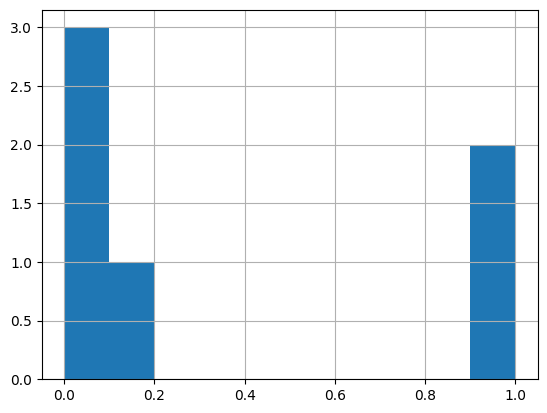

In [ ]:
Omsktest['ratio'].hist() #определим  соотношение

In [ ]:
df_close = Omsktest[(Omsktest['ratio'] > 0.05) & (Omsktest['ratio'] < 0.20)]

In [ ]:
df_close

,id_9460762,id_9460769_x,#2112020,id_9460768,id_9460767,id_9460769_y,id_9460763_x,id_9460763_y,#9460778_x,#9460778_y,#9460797,#9460851,ratio
127406,42778,157364,0,0,49664,157364,0,0,24,24,310026,"986,323.700",0.121


In [ ]:
len(df_close)
#есть 1 наблюдение по Омской области, где непонятно какие факторы будут доминировать (!)

1

In [ ]:
from egttools.behaviors.NormalForm.TwoActions import (Cooperator, Defector, TFT, Pavlov, GRIM, Random, GenerousTFT)
from egttools.plotting.simplified import plot_replicator_dynamics_in_simplex
N = 72 # фиксированное количество факторов, на котором симулируем только распределение без учета размера популяции в "1)"
beta = 1
nb_runs = 10; # количество симмуляций
nb_generations = int(1e7);
transitory = int(1e3);
mutation = - 1e-3

result_matrix  # матрица платежей из прошлого примера
strategies = [GRIM(), TFT(), Random()] # стратегии из egttools, которыми будем моделировать негативные, позитивные и нейтральные факторы

## Скачивание модели

In [119]:
!wget -nc https://raw.githubusercontent.com/brpy/colab-pdf/master/colab_pdf.py
from colab_pdf import colab_pdf
colab_pdf('/content/Иммитационная_модель.ipynb')

File ‘colab_pdf.py’ already there; not retrieving.



W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)


E: Unable to locate package texlive-generic-recommended
[NbConvertApp] WARNING | pattern '$notebookpath$file_name' matched no files
This application is used to convert notebook files (*.ipynb)
        to various other formats.


Options
The options below are convenience aliases to configurable class-options,
as listed in the "Equivalent to" description-line of the aliases.
To see all configurable class-options for some <cmd>, use:
    <cmd> --help-all

--debug
    set log level to logging.DEBUG (maximize logging output)
    Equivalent to: [--Application.log_level=10]
--show-config
    Show the application's configuration (human-readable format)
    Equivalent to: [--Application.show_config=True]
--show-config-json
    Show the application's conf

'File Download Unsuccessful. Saved in Google Drive'